# AirBNB Listings Analysis for Boston and Seattle
Author: Thuy Trinh <br>
Date: 08 Oct 2021 <br>

**Objective**: explore the General characteristics for rental market in the two cities. <br>
Key questions:
1. What is the total number of rooms available for rent listed in AirBNB at the time of data collection? 
2. What type of rooms are offered? What are the average rental rate for each type? Which types are most popular? 
3. What are the areas where most rooms are listed for rent in each city? 

In [181]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

In [111]:
# import data
# boston
calendar_b = pd.read_csv('data/raw/boston/calendar.csv')
listings_b = pd.read_csv('data/raw/boston/listings.csv')
reviews_b = pd.read_csv('data/raw/boston/reviews.csv')
# seattle
calendar_s = pd.read_csv('data/raw/seattle/calendar.csv')
listings_s = pd.read_csv('data/raw/seattle/listings.csv')
reviews_s = pd.read_csv('data/raw/seattle/reviews.csv')

## 1. What is the total number of rooms available for rent listed in AirBNB at the time of data collection? 

In [112]:
## For Boston
# find the time of data collection
collection_date_b = listings_b.last_scraped.unique()[0]
# find the total number of rooms avaiable
nb_rooms_b = len(listings_b.id.unique())

## For Seattle
collection_date_s = listings_s.last_scraped.unique()[0]
nb_rooms_s = len(listings_s.id.unique())

## print results
print(f'As of {collection_date_b}, there are {nb_rooms_b} rooms in Boston listed for rent in AirBNB')
print(f'As of {collection_date_s}, there are {nb_rooms_s} rooms in Seattle listed for rent in AirBNB')

As of 2021-09-19, there are 3123 rooms in Boston listed for rent in AirBNB
As of 2021-09-25, there are 4249 rooms in Seattle listed for rent in AirBNB


In [144]:
print(f'There are {nb_rooms_s-nb_rooms_b} ({round((nb_rooms_s-nb_rooms_b)*100/nb_rooms_b, 0)}%) more listings in Seattle than in Boston')

There are 1126 (36.0%) more listings in Seattle than in Boston


Generally speaking, there are 36% more rooms listed in Seattle than in Boston in September 2021. <br>
Knowing that these two cities are roughly equal in size, based on the number of rooms supply available in the 2 city, we can draw an inital guess that prices in Seattle could be 30% lower than prices in Boston. <br>
Let check this hypothesis.

## 2. What type of rooms are offered? Which types are most popular? What are the average rental rate for each type?

In [147]:
def summarize_by_room_type(df):
    # compute number of rooms for each type and their proportions
    room_type_count = df.room_type.value_counts()
    room_type_props = room_type_count/df.shape[0]
    room_type_df = pd.DataFrame([room_type_count, room_type_props], index=['count', 'propotion']).transpose()
    
    # compute average price per room type
    # create new columns with `price` as numerical value by removing the $ sign
    def _convert_text_to_float(text):
        # removing the $ and , characters
        currency_char = '$,'
        for char in currency_char:
            text = text.replace(char, '')
        # return the text as float
        return float(text)
    sub_df = df[['price', 'room_type', 'beds']]
    sub_df['price'] = sub_df['price'].apply(_convert_text_to_float)
    room_type_price = sub_df[['room_type', 'price', 'beds']].groupby(['room_type']).mean().round(0)
    
    # create a final summary df with counts, percentage, average price, avergage number of beds
    room_type_df = room_type_df.join(room_type_price)
    
    return room_type_df

In [226]:
## For Boston
room_type_b = summarize_by_room_type(listings_b)
room_type_b

count  propotion  price  beds
Entire home/apt  1971.0   0.631124  241.0   2.0
Private room     1115.0   0.357028   96.0   1.0
Hotel room         25.0   0.008005  403.0   1.0
Shared room        12.0   0.003842  123.0   1.0

In [149]:
## For Seattle
room_type_s = summarize_by_room_type(listings_s)
room_type_s

count  propotion  price  beds
Entire home/apt  3501.0   0.823959  180.0   2.0
Private room      703.0   0.165451   84.0   1.0
Shared room        42.0   0.009885   29.0   1.0
Hotel room          3.0   0.000706    0.0   NaN

In [227]:
# create a merge dataframe with data from both cities
room_type_b.columns = [('boston_'+col) for col in room_type_b.columns.to_list()]
room_type_s.columns = [('seattle_'+col) for col in room_type_s.columns.to_list()]
room_type = room_type_b.join(room_type_s)
room_type

boston_count  boston_propotion  boston_price  boston_beds  \
Entire home/apt        1971.0          0.631124         241.0          2.0   
Private room           1115.0          0.357028          96.0          1.0   
Hotel room               25.0          0.008005         403.0          1.0   
Shared room              12.0          0.003842         123.0          1.0   

                 seattle_count  seattle_propotion  seattle_price  seattle_beds  
Entire home/apt         3501.0           0.823959          180.0           2.0  
Private room             703.0           0.165451           84.0           1.0  
Hotel room                 3.0           0.000706            0.0           NaN  
Shared room               42.0           0.009885           29.0           1.0

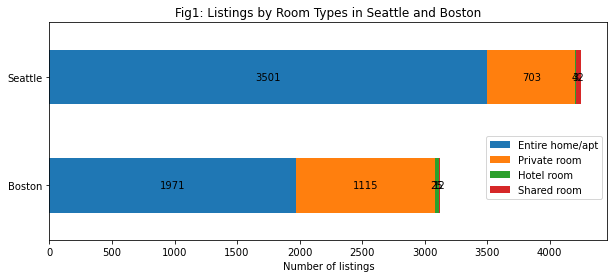

In [274]:
# plot 1: number of listings by room types
# setup dataframe using the dict provided in the OP
plot1 = room_type[['boston_count', 'seattle_count']].transpose()
plot1.index = ['Boston', 'Seattle']
ax = plot1.plot.barh(stacked=True, figsize=(10, 4))
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.title('Fig1: Listings by Room Types in Seattle and Boston')
plt.xlabel('Number of listings')

# annotations:
for c in ax.containers:
    # format the number of decimal places and replace 0 with an empty string
    labels = [f'{w:.0f}' if (w := v.get_width()) > 0 else '' for v in c ]
    ax.bar_label(c, labels=labels, label_type='center')

+ For both cities, there are only 4 types of rooms: `Entire home/apt`, `Private room`, `Shared room` and `Hotel`. <br>
+ The majourity of the rentals are of the class `Entire home/apt` with around 63% of total rents in Boston and 82% of total rents in Seattle. <br>
+ In costrast, there are not a lot of `Shared room` and `Hotel` available for rent in both cities. There are 25 hotels and 12 shared room can be found in AirBNB Boston and in Seattle, there are only 3 hotels and 42 shared rooms listed on AirBNB. 

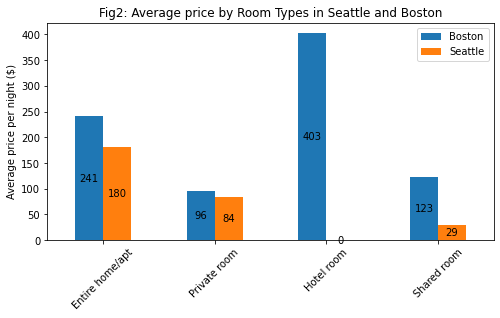

In [271]:
# plot 2: average price by room types
# setup dataframe using the dict provided in the OP
plot2 = room_type[['boston_price', 'seattle_price']]
plot2.columns = ['Boston', 'Seattle']
ax = plot2.plot.bar(stacked=False, figsize=(8, 4))
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.title('Fig2: Average price by Room Types in Seattle and Boston')
plt.ylabel('Average price per night ($)')
plt.xlabel(None)
# annotations:
for c in ax.containers:
    ax.bar_label(c, label_type='center')

+ Rental price in Boston are higher than in Seattle in general. An average house with 2 bedrooms in Boston will cost \$$241\/night, while it is only \$180/night in Seattle, which is 34\% higher. This coincides with the first guess for difference in rental rate based on total number of listings. 

+ Price gap for `Private Room` between the two cities are low, which is \$$96 in Boston and \$84 in Seattle
+ Price for `Hotel Room` is missing and price of `Shared room` are rather too low, this is due to because of missing data for these type of listings in Seattle. 

## 3. What are the areas where most rooms are listed for rent in each city?

In [268]:
def summarize_by_neighbour():
    # compute the proportions of listings by neighbours area in each city
    def _compute_prop_by_neighbour(df):
        neighbour = df['neighbourhood_cleansed'].value_counts().reset_index()
        neighbour.rename(columns={'index': 'neighbourhood', 'neighbourhood_cleansed': 'proportion of total listings'}, inplace=True)
        neighbour.set_index('neighbourhood', inplace=True)
        props_neighbour_df = neighbour/neighbour.sum()
        return props_neighbour_df
    props_neighbour_b = _compute_prop_by_neighbour(listings_b)
    props_neighbour_s = _compute_prop_by_neighbour(listings_s)
    
    # create Horizonal barchart size-by-size
    city_numb=10
    dfs = [props_neighbour_b, props_neighbour_s]
    subtit = [f'Top{city_numb} Neighbourhood Areas in {city}' for city in ['Boston', 'Seattle']]
    # Visualize
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
    fig.tight_layout(pad=13)
    colours = ['c', 'orange']
    for c, df in enumerate(dfs):
        df.head(city_numb).sort_values(by='proportion of total listings', ascending=True).plot(kind='barh', title = subtit[c], 
                                                                        legend=True, ax = ax[c], color=colours[c])
    plt.show()

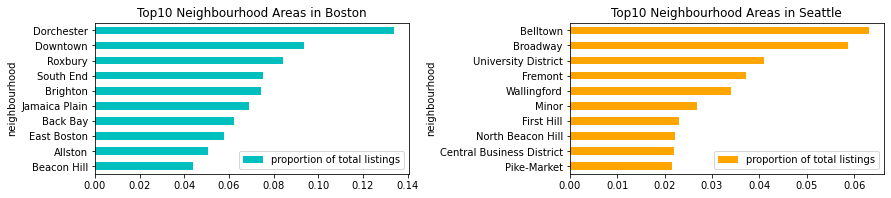

In [269]:
summarize_by_neighbour()

The listings are more concentrated in Boston, where nearly 25% of the total listings are in the top2 neighbourhoods Dorchester and Downtown. <br>
While listings are less concentrated in Seattle, where top2 neighbours Belltown and Broadway only accounts for 12% of total listings.